# Клъстеризация на текст

Тук е представено използването на йерархична клъстеризация за класификация на текст спрямо съдържанието му.

От текста се извличат всички "признаци" (tokens), след което се изчислява честотата им в текста. Нормата на един признак се дефинира като евклидовата норма на вектора с координати честоти на срещане на този признак в различните текстове, т.е. признаците се отъждествяват с вектори в $\mathbb{R}^n$, където $n$ е броят анализирани текстове. Всеки признак се смята, че принадлежи на този текст, на който съответства най-голямата координата. По-долу за това е използван терминът "Dominant text"

Пет текста са групирани в три клъстъра: 
* Клъстър, съдържащ разказите "Индже" и "Шибил" на Йовков. "Съдържащ" в случая означава "съдържащ по-голямата част на признаците". Разказът "Кошута" на същият автор е използван за крос-валидация. Разказите са изтеглени от http://chitanka.info/.
* Клъстър, съдържащ като единствен текст първите десет глави на наказателния кодекс на НРБ от 01.05.1968. За крос-валидация е използван закона за амнистия и връщане на отнети имущества с последна поправка от брой 34 на ДВ от 25 Април 2000г. Документите са изтеглени от https://lex.bg/
* Клъстър, съдържащ статиите от Уикипедия за ПФК Левски и ПФК Ботев. За крос-валидация е използвана статията за Георги Аспарухов. Всичките статии са изтеглени в 16:28 на 02.07.2018.

> Янис Василев, 02.07.2018

In [1]:
# Workspace preparation
library('ggplot2')
options(repr.plot.width=6, repr.plot.height=6)

source('tokenize.R')
source('statistics.R')
source('cleanup.R')
source('clusterize.R')
source('plot.R')
source('classification.R')

In [2]:
# Extract a token data frame from the literary work list
tokens <- tokenizeWorks(c(
    'Й. Йовков - Шибил',
    'Й. Йовков - Индже',
    'Наказателен кодекс, глави 1-10',
    'Уикипедия - ПФК Ботев (Пловдив)',
    'Уикипедия - ПФК Левски (София)'
))

# Display the top ten tokens for each of the works
topWordsTable(tokens, 10)

(1) Й. Йовков - Шибил (2) Й. Йовков - Индже
1  и                     и                    
2  се                    се                   
3  на                    на                   
4  да                    да                   
5  си                    индже                
6  не                    си                   
7  в                     му                   
8  беше                  не                   
9  шибил                 беше                 
10 от                    от                   
   (3) Наказателен кодекс, глави 1-10 (4) Уикипедия - ПФК Ботев (Пловдив)
1  от                                 на                                 
2  г                                  и                                  
3  на                                 в                                  
4  бр                                 за                                 
5  дв                                 от                                 
6  в                                  е                                  
7  изм                                се                                 
8  и                                  ботев                              
9  е                                  с                                  
10 се                                 през                               
   (5) Уикипедия - ПФК Левски (София)
1  на                                
2  и                                 
3  в                                 
4  левски                            
5  през                              
6  е                                 
7  с                                 
8  от                                
9  за                                
10 г

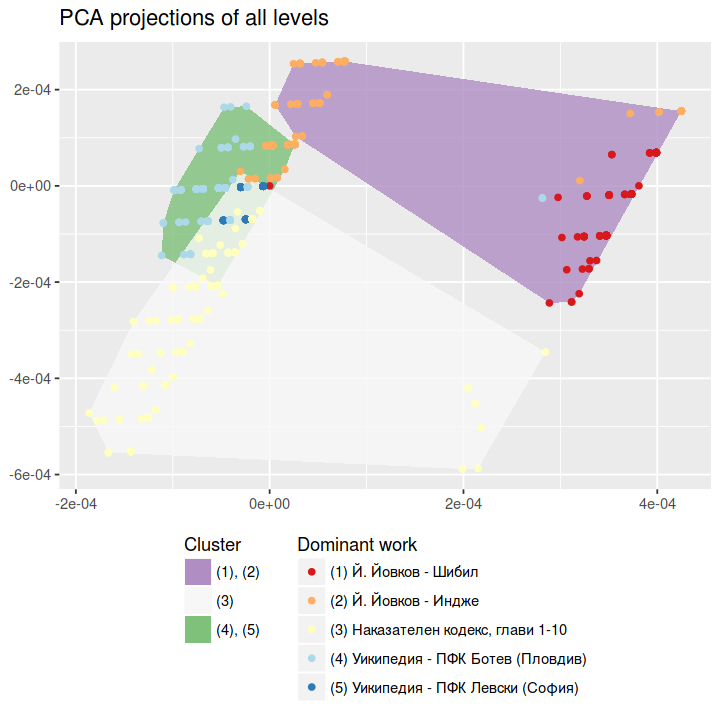

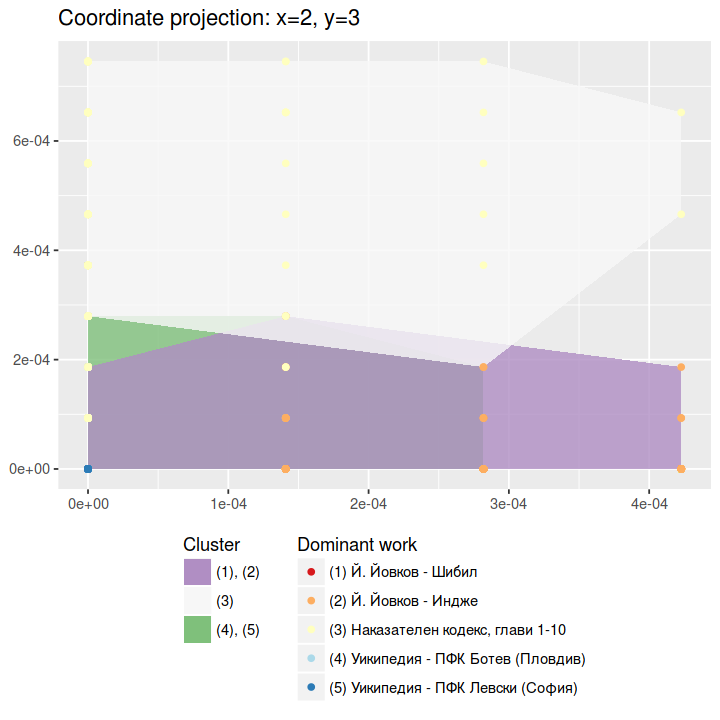

In [3]:
# Clean and clusterize the tokens.

# The cleaning is done by removing the 15 tokens that are cumulatively most common
# to all of the works and then cleaning out outliers, i.e. vectors whose projections
# on the coordinate axes fail the z-test with a confidence value of 0.9.
cleanedTokens <- clearOutliers(clearCommon(tokens, 15), 0.9)

# Clusterize the data into three clusters using hierarchical clustering with complete linkage
mtx <- extractCoordinateMatrix(cleanedTokens)
clusters <- cutree(hclust(dist(mtx), method='complete'), k=3)
clusteredTokens <- analyzeClusterization(cleanedTokens, clusters)

# Plot the PCA-based projection into the plane
plotPCAProjections(clusteredTokens)

# Plot the coordinate projections of (2) and (3)
plotTwoLevels(clusteredTokens, 2:3)

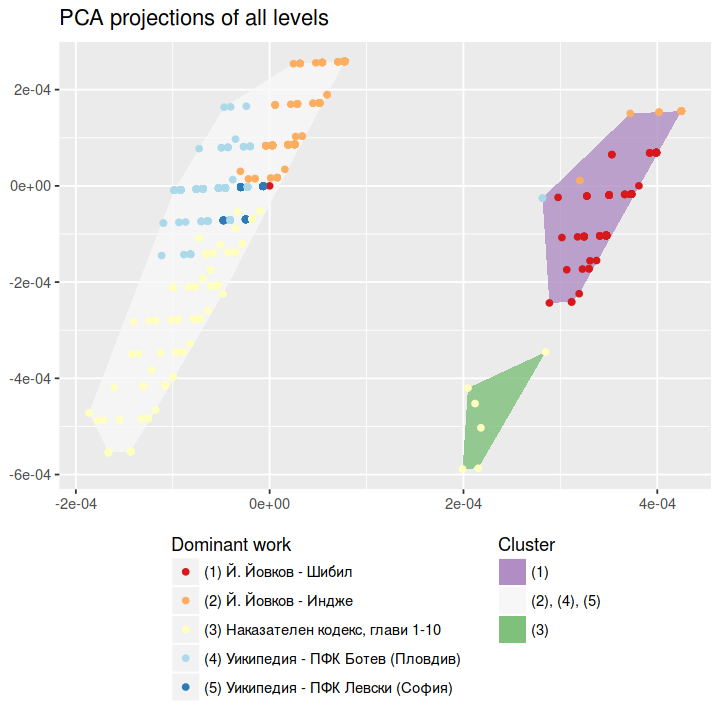

In [4]:
# Use single-linkage clustering on the same data.
# This example shows that the clusterization method dramatically affects the outcome.
clustersSingle <- cutree(hclust(dist(mtx), method='single'), k=3)
clusteredTokensSingle <- analyzeClusterization(cleanedTokens, clustersSingle)
plotPCAProjections(clusteredTokensSingle)

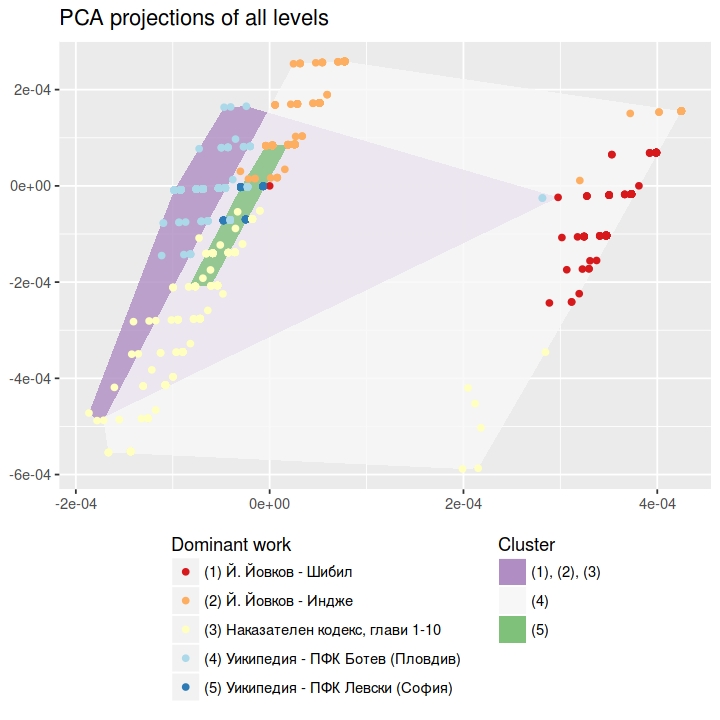

In [5]:
# Use classical (Lloyd) k-means clustering on the same data.
modelLloyd <- kmeans(mtx, 3, algorithm='Lloyd')
clusteredTokensLloyd <- analyzeClusterization(cleanedTokens, modelLloyd$cluster)
plotPCAProjections(clusteredTokensLloyd)

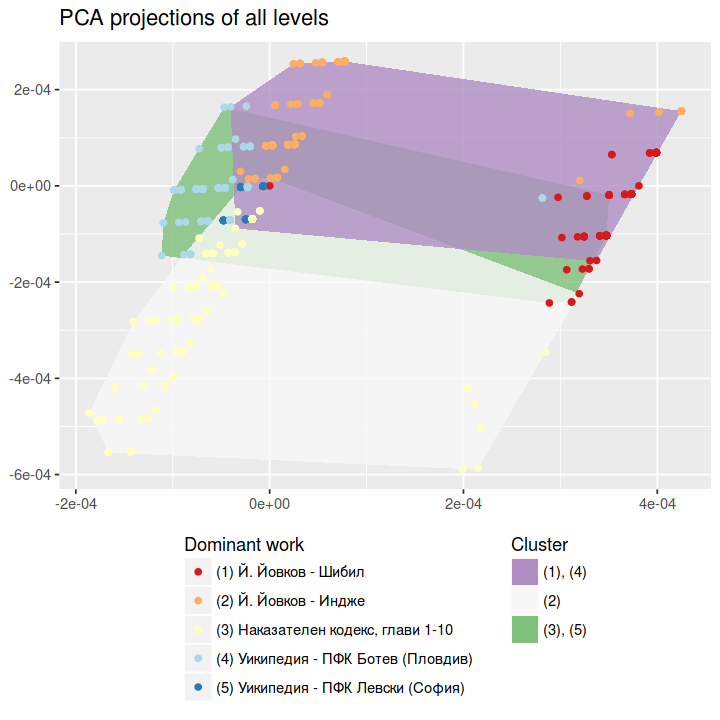

In [6]:
# Use MacQueen k-means clustering on the same data.
modelMacQueen <- kmeans(mtx, 3, algorithm='MacQueen')
clusteredTokensMacQueen <- analyzeClusterization(cleanedTokens, modelMacQueen$cluster)
plotPCAProjections(clusteredTokensMacQueen)

In [7]:
scaleToSmallNumbers <- function (value) {
    value * 10^(-floor(log10(value)))
}

# Compare the within-cluster sums of squares
withinss <- data.frame(Lloyd=modelLloyd$withinss, MacQueen=modelMacQueen$withinss)
scaleToSmallNumbers(withinss)

Lloyd    MacQueen
1 7.828887 8.548649
2 2.074166 5.410549
3 2.680655 3.722780

In [8]:
# Use the complete-linkage clusterization to classify a few texts for cross-validation
source('classification.R')

classifyWorks(
    clusteredTokens,
    c(
        'Й. Йовков - Кошута',
        'Закон за амнистия и връщане на отнети имущества',
        'Уикипедия - Георги Аспарухов'
    )
)

work                                            cluster 
1 Й. Йовков - Кошута                              (1), (2)
2 Закон за амнистия и връщане на отнети имущества (3)     
3 Уикипедия - Георги Аспарухов                    (4), (5)